# Graph
This is the code that takes the dataframe and turns it into a graph

In [14]:
import pandas as pd
from tqdm import tqdm
from joblib import Parallel, delayed
from collections import defaultdict
import netwulf as nw
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import json
from networkx.readwrite import json_graph

Loading merged dataframe

In [4]:
df = pd.read_csv("data/Merged_Reviews_and_Metadata.csv")
print(df.shape)
df_graph = df[['user_id', 'parent_asin']].dropna().drop_duplicates()
print(df_graph.shape)

C:\Users\mia\AppData\Local\Temp\ipykernel_42172\4160206767.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/Merged_Reviews_and_Metadata.csv")


(755717, 14)
(748023, 2)


In [6]:
# 2. Create bidirectional mappings
print("Creating mappings...")
# ASIN to reviewers
asin_to_reviewers = defaultdict(set)
# Reviewer to ASINs
reviewer_to_asins = defaultdict(set)

for _, row in tqdm(df_graph.iterrows(), total=len(df_graph)):
    asin_to_reviewers[row['parent_asin']].add(row['user_id'])
    reviewer_to_asins[row['user_id']].add(row['parent_asin'])

Creating mappings...


100%|██████████| 748023/748023 [00:20<00:00, 37195.55it/s]


In [8]:
# 3. Create graph and add nodes
G = nx.Graph()
G.add_nodes_from(asin_to_reviewers.keys())

In [9]:
# 4. Parallel edge computation
def compute_edges_for_asin(asin, asin_to_reviewers, all_asins):
    edges = []
    # Get all other ASINs that share at least one reviewer
    co_reviewed_asins = set()
    for reviewer in asin_to_reviewers[asin]:
        co_reviewed_asins.update(reviewer_to_asins[reviewer])
    
    # Remove self and already processed pairs
    co_reviewed_asins.discard(asin)
    co_reviewed_asins = [a for a in co_reviewed_asins if all_asins.index(a) > all_asins.index(asin)]
    
    for other_asin in co_reviewed_asins:
        weight = len(asin_to_reviewers[asin] & asin_to_reviewers[other_asin])
        if weight > 0:
            edges.append((asin, other_asin, weight))
    return edges

print("Computing edges in parallel...")
all_asins = list(asin_to_reviewers.keys())
results = Parallel(n_jobs=-1, prefer="threads")(
    delayed(compute_edges_for_asin)(asin, asin_to_reviewers, all_asins)
    for asin in tqdm(all_asins)
)

Computing edges in parallel...


100%|██████████| 21412/21412 [08:41<00:00, 41.05it/s]


In [10]:
# 5. Add edges to graph
print("Building graph...")
for edges in tqdm(results):
    for asin1, asin2, weight in edges:
        G.add_edge(asin1, asin2, weight=weight)

print(f"Graph constructed with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

Building graph...


100%|██████████| 21412/21412 [00:02<00:00, 9658.74it/s] 

Graph constructed with 21412 nodes and 1282957 edges


In [11]:
nw.visualize(G)

(None, None)

Node count: 21412
Edge count: 1282957


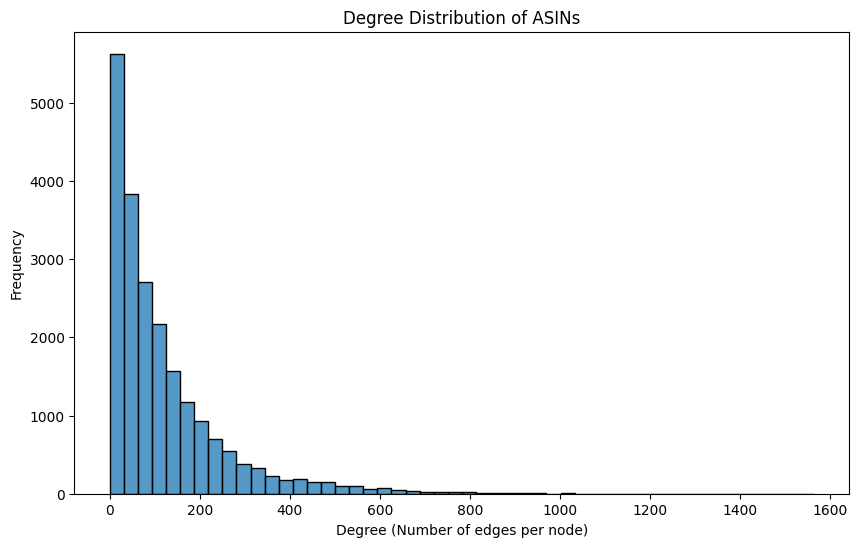

In [13]:
# Node count
node_count = G.number_of_nodes()
print(f"Node count: {node_count}")

# Edge count
edge_count = G.number_of_edges()
print(f"Edge count: {edge_count}")

degrees = [deg for node, deg in G.degree()]
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]

plt.figure(figsize=(10, 6))
sns.histplot(degrees, bins=50, kde=False)
plt.title(f"Degree Distribution of ASINs")
plt.xlabel('Degree (Number of edges per node)')
plt.ylabel('Frequency')
plt.show()

In [15]:
graph_data = json_graph.node_link_data(G)
with open("network.json", "w") as f:
    json.dump(graph_data, f, indent = 4)